### Deskriptive und Explorative Datenanalyse

In [1]:
from enum import Enum
import ipywidgets as widgets
from pandas import read_csv
import pandas as pd
import asammdf
from IPython.display import display
import os
import numpy as np
import time
import pathlib as pl

ldf is not supported
xls is not supported
xlsx is not supported
yaml is not supported


In [23]:
# Setting up the global variables

# PATH_RAW_DATA = "../Messdaten"
PATH_RAW_DATA = r"E:\Messdaten"
PATH_FEATURE_DATA = "./data/"
PATH_EXPLORATION_DATA = "./exploration/"
PATH_MODEL = "./models/"
DATA_SOURCE_KIDAQ = ["TEST_NAME", "TEST_TYPE", "RPM", "FLOW_RATE", "P1", "P2"]
RAW_DATA_TYPE = ["KIDAQ", "VIB"]

DATA_SOURCE_VID = [
    "TEST_NAME",
    "TEST_TYPE",
    "RPM",
    "FLOW_RATE",
    "S1",
    "S2",
    "S3",
    "S4",
    "S5",
    "S6",
    "S7",
    "S8",
]
FEATURE = [
    "STD",
    "RANGE",
    "IQR",
    "MEAN_MEDIAN",
    "FFT",
]
OPERATING_POINT_FREQ = [725, 1450, 2175, 2900]
OPERATING_POINT_FLOW_RATE = [0, 25, 50, 75, 100]

PREPROCESSING_WINDOW_SIZE_MS_DEFAULT = 1000
PREPROCESSING_WINDOW_SIZE_MS_MIN = 100
PREPROCESSING_WINDOW_SIZE_MS_MAX = 10000

PREPROCESSING_FREQUENCY_BAND_COUNT_DEFAULT = 10
PREPROCESSING_FREQUENCY_BAND_COUNT_MIN = 10
PREPROCESSING_FREQUENCY_BAND_COUNT_MAX = 100

DEFAULT_RAW_DATA_TYPE = RAW_DATA_TYPE[1]
DEFAULT_RAW_DATA = DATA_SOURCE_KIDAQ
DEFAULT_SAMPLE_RATE = 10000

DEFAULT_CLASS_LABEL = "TEST_TYPE"
# 2021-04-28 - Gut 1, 2021-05-19 - Kavitation 1, 2021-05-26 - Fehlausrichtung 1, 2021-07-10 - Laufradschaden 1
TEST_TYPES = ["Gut", "Kavitation", "Fehlausrichtung", "Laufradschaden"]
TEST_TYPE_REGEX = r"\b(?:" + "|".join(TEST_TYPES) + r")\b"

# ..\Messdaten\Setup-I\2021-04-28 - Gut 1\KiDAQ\1450rpm\1450rpm@100%.mf4
TEST_NAME_REGEX = r"\d{4}-\d{2}-\d{2} - [\w\s]+"

KIDAQ_FILE_SEARCH_PATTERN = "**/*.mf4"  # 725rpm@0%.mf4
KIDAQ_FILE_RPM_REGEX = r"(\d+)rpm"
KIDAQ_FILE_FLOW_RATE_REGEX = r"(\d+)%"


KIDAQ_DEFAULT_FEATURES = [
    "test_name",
    "test_type",
    "flow_rate",
    "rpm",
    "p1_std",
    "p2_std",
    "p1_range",
    "p2_range",
    "p1_iqr",
    "p2_iqr",
    "p1_mean_median",
    "p2_mean_median",
]

VIB_DEFAULT_FEATURES = [
    "test_name",
    "test_type",
    "flow_rate",
    "rpm",
    "s1_std",
    "s2_std",
    "s3_std",
    "s4_std",
    "s5_std",
    "s6_std",
    "s7_std",
    "s8_std",
    "s1_range",
    "s2_range",
    "s3_range",
    "s4_range",
    "s5_range",
    "s6_range", 
    "s7_range",
    "s8_range",
    "s1_iqr",
    "s2_iqr",
    "s3_iqr",
    "s4_iqr",
    "s5_iqr",
    "s6_iqr",
    "s7_iqr",
    "s8_iqr",
    "s1_mean_median",
    "s2_mean_median",
    "s3_mean_median",
    "s4_mean_median",
    "s5_mean_median",
    "s6_mean_median",
    "s7_mean_median",
    "s8_mean_median"
]
    
# 2900_25_1.mf4

KIDAQ_FILE_FIX_REGEX = r"(\d+)_(\d+)_(\d+).mf4"


VIB_FILE_SEARCH_PATTERN = (
    "**/VIB*.csv"  # 725rpm\0%\1\VIB1 2021-05-03 10-58-02.453.519.300.csv
)
VIB_FILE_SENSOR_REGEX = r"VIB(\d+)"
VIB_FILE_RPM_REGEX = r"(\d+)rpm"
VIB_FILE_FLOW_RATE_REGEX = r"(\d+)%"
VIB_SENSOR_COUNT = 8


DATANALYSIS_WINDOW_SIZE_DEFAULT = 100000
DATANALYSIS_WINDOW_SIZE_MIN = 0
DATANALYSIS_WINDOW_SIZE_MAX = 1000000

DATANALYSIS_STEP_SIZE_DEFAULT = 100000
DATANALYSIS_STEP_SIZE_MIN = 0
DATANALYSIS_STEP_SIZE_MAX = 1000000

In [127]:
windowSizeSlider = widgets.IntSlider(
    value=DATANALYSIS_WINDOW_SIZE_DEFAULT,
    min=DATANALYSIS_WINDOW_SIZE_MIN,
    max=DATANALYSIS_WINDOW_SIZE_MAX,
    step=100,
    description='Window size:'
)
display(windowSizeSlider)

stepSizeSlider = widgets.IntSlider(
    value=DATANALYSIS_STEP_SIZE_DEFAULT,
    min=DATANALYSIS_STEP_SIZE_MIN,
    max=DATANALYSIS_STEP_SIZE_MAX,
    step=100,
    description='Step size:'
)
display(stepSizeSlider)

setups = list(filter(lambda x: os.path.isdir(os.path.join(PATH_RAW_DATA, x)), os.listdir(PATH_RAW_DATA)))
setupSelectionDropdown = widgets.Dropdown(
    options=setups,
    description='Setup:'
)
display(setupSelectionDropdown)

# list all folder in the selected setup and order by name of folder
seriesNames = sorted(list(filter(lambda x: os.path.isdir(os.path.join(PATH_RAW_DATA, setupSelectionDropdown.value, x)), os.listdir(os.path.join(PATH_RAW_DATA, setupSelectionDropdown.value)))))
seriesDropdown = widgets.Dropdown(
    options=seriesNames,
    description='Series:',
    value=seriesNames[1]
)
# if setupSelectionDropdown.value changes update seriesDropdown
def updateSeriesDropdown(change):
    seriesNames = sorted(list(filter(lambda x: os.path.isdir(os.path.join(PATH_RAW_DATA, setupSelectionDropdown.value, x)), os.listdir(os.path.join(PATH_RAW_DATA, setupSelectionDropdown.value)))))
    seriesDropdown.options = seriesNames
setupSelectionDropdown.observe(updateSeriesDropdown, names='value')
display(seriesDropdown)

dataSourceDropdown = widgets.Dropdown(
    options=RAW_DATA_TYPE,
    description='Data source:',
    value=RAW_DATA_TYPE[0]
)
display(dataSourceDropdown)


# create Pathlib Path to the selected series
def createPathToSeries(setup, series):
    return os.path.join(PATH_RAW_DATA, setup, series)

# list all files in all subfolders of createPathToSeries if data source is KIDAQ file should end with .mf4 else with .csv use function createPathToSeries
def listFilesInPath(path):
    files = []
    if dataSourceDropdown.value == 'KIDAQ':
        for file in pl.Path(path).glob(KIDAQ_FILE_SEARCH_PATTERN):
            # append full file path as string to files list
            files.append(file) 
    else:
        if path is None:
            return []
        for file in pl.Path(path).glob(VIB_FILE_SEARCH_PATTERN):
            files.append(file)
    return sorted(files)

fileDropdown = widgets.Dropdown(
    options=listFilesInPath(createPathToSeries(setupSelectionDropdown.value, seriesDropdown.value)),
    description='File:'
)
# if one of the dropdowns changes update fileDropdown
def updateFileDropdown(change):
    fileDropdown.options = listFilesInPath(createPathToSeries(setupSelectionDropdown.value, seriesDropdown.value))
setupSelectionDropdown.observe(updateFileDropdown, names='value')
seriesDropdown.observe(updateFileDropdown, names='value')
dataSourceDropdown.observe(updateFileDropdown, names='value')
display(fileDropdown)

aggregationDropdown = widgets.Dropdown(
    options=['median', 'std', 'min', 'max'],
    value='median',
    description='Aggregation:',
    disabled=False,
)
display(aggregationDropdown)

IntSlider(value=100000, description='Window size:', max=1000000, step=100)

IntSlider(value=100000, description='Step size:', max=1000000, step=100)

Dropdown(description='Setup:', options=('Setup-I', 'Setup-II'), value='Setup-I')

Dropdown(description='Series:', index=1, options=('2021-04-28 - Gut 1', '2021-04-30 - Gut 2', '2021-05-19 - Ka…

Dropdown(description='Data source:', options=('KIDAQ', 'VIB'), value='KIDAQ')

Dropdown(description='File:', options=(WindowsPath('E:/Messdaten/Setup-I/2021-04-30 - Gut 2/KiDAQ/1450rpm/1450…

Dropdown(description='Aggregation:', options=('median', 'std', 'min', 'max'), value='median')

In [135]:
# read the selected file with pandas
def fileToDataframe(pathString, dataSource):
    if pathString is None:
        return pd.DataFrame()
    path = pl.Path(pathString)
    if dataSource == 'KIDAQ':
        return asammdf.MDF(path).to_dataframe()
    else:
        # header is in the 3rd row and Timestamp[ns] is the index column
        return pd.read_csv(path, sep=';', encoding = "ISO-8859-1", header=2, index_col=0)
    
df = fileToDataframe(fileDropdown.value, dataSourceDropdown.value)

multiselectColumns = widgets.SelectMultiple(
    options=fileToDataframe(fileDropdown.value, dataSourceDropdown.value).columns.to_list(),
    description='Columns:',
    disabled=False
)
display(multiselectColumns)

SelectMultiple(description='Columns:', options=('Value',), value=())

In [136]:
def createPlot(columnTuple, aggregation, windowSize, stepSize, file, dataSource):
    columnList = list(columnTuple)
    # if no columns are selected return
    if len(columnList) == 0:
        return
    df = fileToDataframe(file, dataSource)
    # drop all columns that are not selected
    df = df[columnList]
    df_agg = df.rolling(
        window=windowSize,
        step=stepSize,
    ).agg(aggregation)
    # set title to the name of the selected file
    title=file.name
    # plot data
    df_agg.plot(title=title, grid=True)

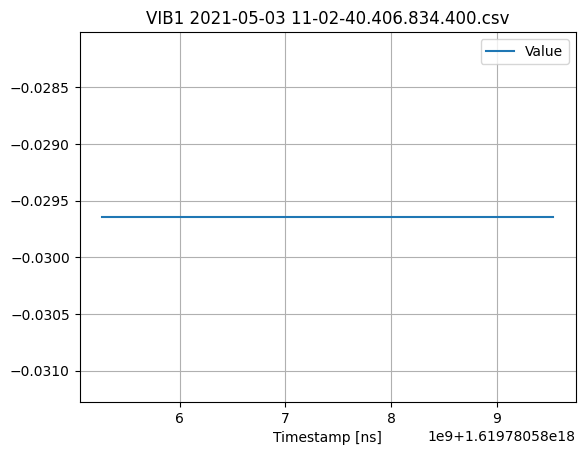

In [137]:
createPlot(multiselectColumns.value, aggregationDropdown.value, windowSizeSlider.value, stepSizeSlider.value, fileDropdown.value, dataSourceDropdown.value)